## <font color='red'><b>Part 2</b></font> : Deep Q-Learning for Acrobot task


In [ ]:
!pip install gymnasium[classic-control]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 6.3 MB/s eta 0:00:00


In [ ]:
import torch
import numpy as np
import torch.nn as nn
from scipy import stats
import gymnasium as gym
from random import sample
from collections import deque
import torch.nn.functional as F
import matplotlib.pyplot as plt
from gym.wrappers.monitoring.video_recorder import VideoRecorder

In [ ]:
env = gym.make('Acrobot-v1')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
class DeepQNetwork(nn.Module):

    def __init__(self, input_dim, output_dim):

        super(DeepQNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_dim)

    def forward(self, state):

        x_fc1 = F.relu(self.fc1(state))
        x_fc2 = F.relu(self.fc2(x_fc1))
        q_value = self.fc3(x_fc2)
        return q_value

In [ ]:
class DQAgent():

    def __init__(self, network_type='simple', env=env, gamma=0.99, epsilon=0.1,num_episodes=200,
                 rb_size=300, batch_rb_size=100,
                 tar_net_update_period=100, num_epochs=5):

        self.env = env
        self.gamma = gamma
        self.num_episodes = num_episodes
        self.epsilon = epsilon
        self.num_action = env.action_space.n
        self.action_space = [i for i in range(self.num_action)]
        self.state_dim = env.observation_space.shape[0]
        self.rb_size = rb_size          # size of replay buffer
        self.batch_rb_size = batch_rb_size          # batch size used for training for replay buffer
        self.tar_net_update_period = tar_net_update_period           # it shows after "tar_net_update_period" update the target network weights
        self.tar_net_update_index = 0           # this incremented after each update and whet it equals with "tar_net_update_period" we update the weights of target network
        self.epochs = num_epochs

        if network_type == 'simple':
            self.online_network = DeepQNetwork(self.state_dim, self.num_action)        # this the network that we train it as fuction approximator
            self.target_network = DeepQNetwork(self.state_dim, self.num_action)        # this is the netwok that we use for predic the true value for training

        elif network_type == 'dueling':
            self.online_network = DDQNetwork(self.state_dim, self.num_action)
            self.target_network = DDQNetwork(self.state_dim, self.num_action)

        else :
            raise ValueError('Invalid type of network !!')

        self.online_network_optim = torch.optim.Adam(self.online_network.parameters(), lr=0.01)
        self.target_network_optim = torch.optim.Adam(self.target_network.parameters(), lr=0.01)

        self.loss_network = nn.MSELoss()

        self.target_network.load_state_dict(self.online_network.state_dict())
        self.replay_buffer = deque(maxlen=self.rb_size)
        self.rewards = []           # this attribute returns the cumulative reward of each episode

    def get_action(self, state, episode_number):

        p = np.random.uniform()
        state = torch.Tensor(list(state))

        state_q_values = self.online_network(state)
        state_q_values = state_q_values.detach().numpy()

        if episode_number > 100 :
            self.epsilon *= 0.95

        if p < self.epsilon:
            return np.random.choice(self.action_space)

        else :

            action = np.argmax(state_q_values)

            return action

    def train_network(self):

        # for _ in range(self.epochs):

        if len(self.replay_buffer) > self.batch_rb_size:


            batch = sample(self.replay_buffer, self.batch_rb_size)
            current_states, actions, rewards, next_states, is_terminal = np.array([x[0] for x in batch]), np.array([x[1] for x in batch]), np.array([x[2] for x in batch]),\
                                                                        np.array([x[3] for x in batch]) , np.array([x[4] for x in batch])
            current_states = torch.Tensor(current_states)
            actions = torch.Tensor(actions)
            rewards = torch.Tensor(rewards)
            next_states = torch.Tensor(next_states)
            is_terminal = torch.Tensor(is_terminal)

            q_values_current_states = self.online_network(current_states)
            initial_q_values = q_values_current_states.clone()

            q_values_next_states = self.target_network(next_states)


            for i in range(self.batch_rb_size):

                not_terminal = not is_terminal[i]
                y = not_terminal*self.gamma*float(max(q_values_next_states[i])) + float(rewards[i])
                q_values_current_states[i][int(actions[i])] = y

            # for e in range(10):
            self.online_network.train()
            loss = self.loss_network(initial_q_values, q_values_current_states.detach())
            self.online_network_optim.zero_grad()
            loss.backward()
            self.online_network_optim.step()

            self.tar_net_update_index += 1

            if self.tar_net_update_index == self.tar_net_update_period:

                self.target_network.load_state_dict(self.online_network.state_dict())
                self.tar_net_update_index = 0


    def episode(self):

        for i in range(self.num_episodes):

            episode_reward = 0
            done = False
            state, _ = self.env.reset()

            while not done:

                act = self.get_action(state, i)
                next_state, reward, is_terminal, is_truncated, _ = self.env.step(act)
                episode_reward += reward
                self.replay_buffer.append((state, act, reward, next_state, is_terminal))

                self.train_network()

                state = next_state
                done = is_terminal or is_truncated

            # print("Sum of rewards {}".format(episode_reward))
            # print("Episode Number is {}".format(i+1))
            # print("*****************************************")
            self.rewards.append(episode_reward)

In [ ]:
num_runs = 10
runs_rewards = []

for i in range(num_runs):

    agent = DQAgent()
    agent.episode()
    runs_rewards.append(agent.rewards)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def plot(all_rewards):

    num_runs = len(all_rewards)

    _, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 14))

    for i in range(num_runs):

        ax2.plot(all_rewards[i])

        ax2.set_title("Reward over episodes")
        ax2.set_xlabel("Episode")
        ax2.set_ylabel("Reward")

    # Calculate the mean and standard deviation of the reward sequences
    mean_reward = np.mean(all_rewards, axis=0)
    std_reward = np.std(all_rewards, axis=0)

    # Calculate the confidence interval for the mean reward
    upper_bound_reward = mean_reward + 1.96 * std_reward / np.sqrt(num_runs)
    lower_bound_reward = mean_reward - 1.96 * std_reward / np.sqrt(num_runs)

    ax1.plot(mean_reward, label="Mean Reward")
    ax1.fill_between(np.arange(len(mean_reward)), lower_bound_reward ,upper_bound_reward , alpha=0.5, label="95% Confidence Interval")



    # Set the title and labels
    ax1.set_title("Mean Regward of 10 Run with 95% Confidence Interval")
    ax1.set_xlabel("Episode")
    ax1.set_ylabel("Reward")

    plt.show()


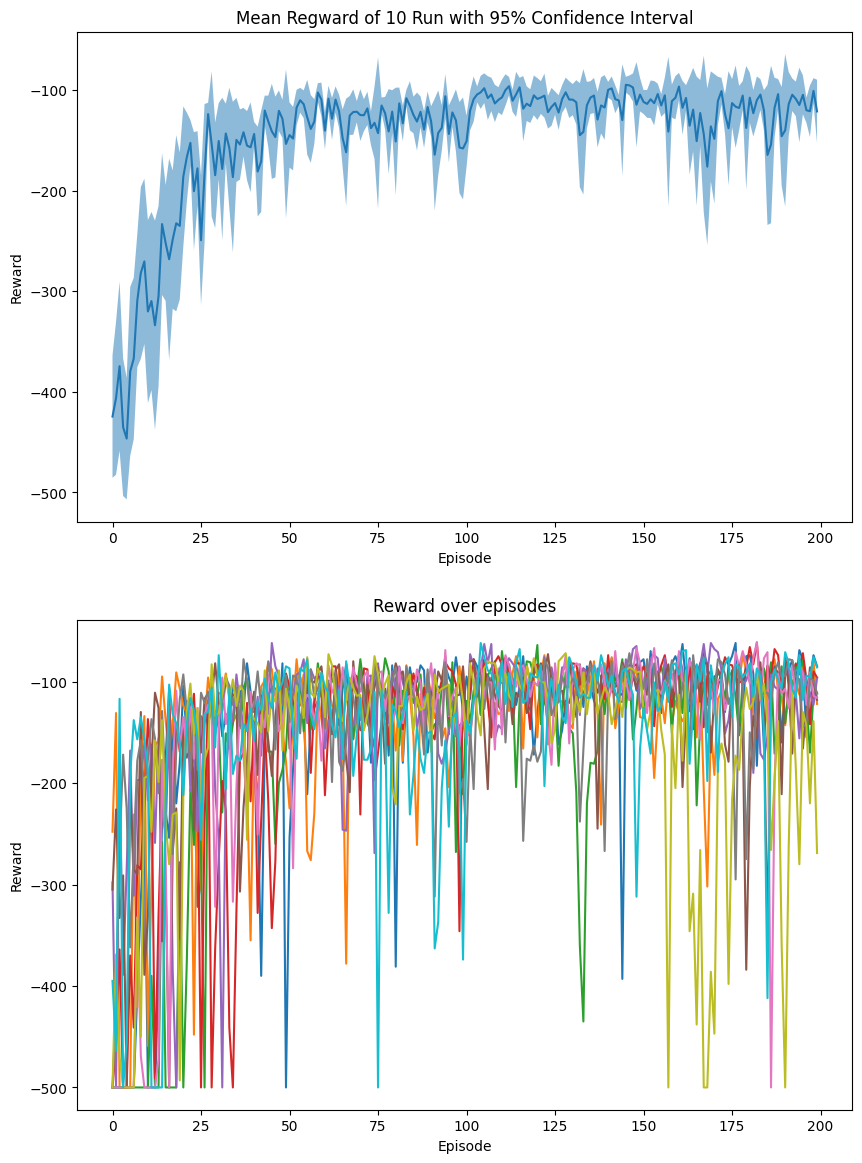

In [ ]:
plot(runs_rewards)

### Rendering


In [ ]:
agent_video = DQAgent(num_episodes=300)
agent_video.episode()

In [ ]:
env = gym.make("Acrobot-v1",render_mode='rgb_array')

In [ ]:
path = "./training.mp4"  # the video is going to save in the "Files" with this name
model = agent_video.online_network
video = VideoRecorder(env, path)

state, _ = env.reset()
state = torch.Tensor(state)
done = False

while not done:

  env.render()
  video.capture_frame()
  q_values = model(state)
  q_values = q_values.detach().numpy()
  action = np.argmax(q_values)
  next_state, reward, is_terminal, is_truncated, _ = env.step(action)
  state = torch.Tensor(next_state)
  done = is_terminal or is_truncated


video.close()
env.close()

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


## <font color='red'><b>Part 3</b></font> : Dueling Deep Q-Learning for Acrobot task


In [ ]:
class DDQNetwork(nn.Module):

    def __init__(self, input_dim, output_dim):

        super(DDQNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.v = nn.Linear(64, 1)
        self.a = nn.Linear(64, output_dim)

    def forward(self, state):

        x_fc1 = F.relu(self.fc1(state))
        x_fc2 = F.relu(self.fc2(x_fc1))
        v = self.v(x_fc2)
        a = self.a(x_fc2)
        q_value = v + (a - torch.mean(a, dim=0, keepdim=True))

        return q_value

In [ ]:
simple_agent = DQAgent()
ddq_agent = DQAgent(network_type="dueling")

In [ ]:
simple_agent.episode()

In [ ]:
ddq_agent.episode()

In [ ]:
simple_agent_results = simple_agent.rewards
ddq_agent_results = ddq_agent.rewards

print("Average reward for simple DQN : %s"%np.mean(simple_agent_results))
print("Average reward for dueling DQN : %s"%np.mean(ddq_agent_results))

Average reward for simple DQN : -128.85
Average reward for dueling DQN : -452.895


In [ ]:
# Perform t-test
t_statistic, p_value = stats.ttest_ind(simple_agent_results, ddq_agent_results)

# Print the results
print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

T-Statistic: 38.58920771893889
P-Value: 1.3969462802703429e-136


#### The t-statistic represents the calculated value of the t-test, and the p-value represents the probability of observing such an extreme difference between the two models' results by chance alone. In this case, the p-value is <font color='red'>1.3969462802703429e-136</font>, which is smaller than the commonly used significance level of <font color='red'>0.05</font>. Therefore, we have enough evidence to reject the null hypothesis that <font color='green'> there is no significant difference between the two models.</font> So we have difference between these two models and abviously the simple model works better than dueling DQN for this task here !